In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qlearning import *
from spider_ani import *
from wait import *

# Spider Environment

In [2]:
class spider_environment: 
    def __init__(self):
        # number of states: leg up/down, forward/backward
        self.n_states = pow(4,4)         
        self.n_actions = pow(4,4)        # number of actions 
        self.reward = np.zeros([self.n_states, self.n_actions])
        # 1 if terminal state, 0 otherwise
        self.terminal = np.zeros(self.n_states, dtype=np.int) 
        self.next_state = np.zeros([self.n_states, self.n_actions], dtype=np.int)        
        self.init_state = 0b00001010    # initial state
        n_legs = 4
        transition = [[1,0,2,0],[1,0,3,1],[3,2,2,0],[3,2,3,1]]
        class leg: pass
        # loop to calculate next state and rewards for each initial state
        for s in range(self.n_states):
            legs_state = []
            down_s = ""
            # storing initial leg position
            for l in range(n_legs):
                leg_i = leg()
                leg_i.up = (s >> 2*l) & 1
                leg_i.fw = (s >> (2*l +1)) & 1
                legs_state += [leg_i]
                # initial arrangement of legs: 1 if up 0 if down
                down_s = bin(leg_i.up ^ 0b1)[2:] + down_s
            down_s = int("0b"+down_s, 2)
            for a in range(self.n_actions):
                legs_action = []
                # storing actions for each leg
                for l in range(n_legs):
                    leg_i = leg()
                    leg_i.action_up = ((a >> 2*l) & 3) == 0
                    leg_i.action_dn = ((a >> 2*l) & 3) == 1
                    leg_i.action_fw = ((a >> 2*l) & 3) == 2
                    leg_i.action_bw = ((a >> 2*l) & 3) == 3
                    legs_action += [leg_i]
                next_s = 0
                down_sn = "0b"
                # start from MSB and move to LSB
                # computing next state for each leg independently using
                # the transition table
                for l in reversed(range(n_legs)):
                    s_i = (s >> 2*l) & 3
                    a_i = (a >> 2*l) & 3
                    next_s = (next_s << 2) + transition[s_i][a_i] 
                    # arrangement of legs in next state: 1 if up 0 if down
                    down_sn += bin((transition[s_i][a_i] & 1) ^ 0b1)[2:]
                down_sn = int(down_sn, 2)
                self.next_state[s,a] = next_s
                # total arrangement of legs which stay down at s and sn
                product = (down_s) & (down_sn)
                total_down = bin(product).count("1")
                total_force = 0
                for l in range(n_legs):
                    total_force += (legs_state[l].up == 0 and legs_state[l].fw == 1 \
                    and legs_action[l].action_bw == 1) - (legs_state[l].up == 0 and \
                            legs_state[l].fw == 0 and legs_action[l].action_fw == 1)
                # two diagonal legs stay down in two cases
                # either product=0110 or product=1001
                diagonal = ((product & 1) & ((product >> 3)& 1)) | \
                                    (((product >> 2) & 1) & ((product >> 1)& 1))

                if total_down == 0:
                    self.reward[s,a] = 0
                elif total_down >= 3:
                    self.reward[s,a] = 1.0 * total_force / total_down
                elif total_down == 2 and diagonal:
                    self.reward[s,a] = 1.0 * total_force / total_down
                else:
                    self.reward[s,a] = 0.25 * total_force / total_down

# Hyperparameters

Were chosen empirically such that $r_{test}>9$

In [3]:
env = spider_environment()

n_episodes = 1       # number of episodes to run, 1 for continuing task
max_steps = 5000000      # max number of steps to run in each episode
alpha = 0.2          # learning rate
gamma = 0.9

class epsilon_profile: pass
epsilon = epsilon_profile()
epsilon.init = 1.    # initial epsilon in e-greedy
epsilon.final = 0.0   # final epsilon in e-greedy
epsilon.dec_episode = 0.  # amount of decrement in each episode
epsilon.dec_step = 1. / max_steps   # amount of decrement in each step

# Training and testing
First train agent for 5000000 steps and then reuse Q table for deterministic greedy policy w.r.t. state-action values

train_sum_rewards = 1026679.958333
Testing
s 		 a 	 sn 	 r
    0b1010 0b11000011    0b11100  0.50
   0b11100   0b101000  0b1111101  0.00
 0b1111101 0b10010110 0b11101011  0.00
0b11101011  0b1111101 0b10000010  1.00
0b10000010 0b11000011    0b10100  1.00
   0b10100   0b101000  0b1111101  0.00
 0b1111101 0b10010110 0b11101011  0.00
0b11101011  0b1111101 0b10000010  1.00
0b10000010 0b11000011    0b10100  1.00
   0b10100   0b101000  0b1111101  0.00
 0b1111101 0b10010110 0b11101011  0.00
0b11101011  0b1111101 0b10000010  1.00
0b10000010 0b11000011    0b10100  1.00
   0b10100   0b101000  0b1111101  0.00
 0b1111101 0b10010110 0b11101011  0.00
0b11101011  0b1111101 0b10000010  1.00
0b10000010 0b11000011    0b10100  1.00
   0b10100   0b101000  0b1111101  0.00
 0b1111101 0b10010110 0b11101011  0.00
0b11101011  0b1111101 0b10000010  1.00
test_sum_rewards = 9.500000


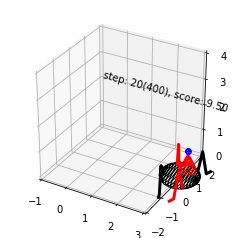

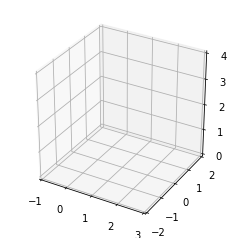

Press enter to quit


In [4]:
Q, n_steps, sum_rewards = Q_learning_train(env, n_episodes, max_steps, alpha, \
                                           gamma, epsilon)
print("train_sum_rewards = %f"%sum_rewards[0])

test_n_episodes = 1  # number of episodes to run, 1 for continuing task
test_max_steps = 20  # max. # of steps to run in each episode
test_epsilon = 0.0    # test epsilon
test_n_steps, test_sum_rewards, s, a, sn, r = Q_test(Q, env, test_n_episodes, \
                                          test_max_steps, test_epsilon)
print("Testing")
print("s \t\t a \t sn \t r")
for j in range(test_max_steps):
    print('%10s %10s %10s %5.2f' % (bin(s[0,j]), bin(a[0,j]), bin(sn[0,j]), r[0,j]))
print("test_sum_rewards = %f"%test_sum_rewards[0])

ani = spider_animation(Q, env, test_max_steps, test_epsilon, frames_per_step = 20)
ani.save('spider.mp4', dpi=200)
ani = spider_animation(Q, env, test_max_steps, test_epsilon, frames_per_step = 5)
plt.show(block=False)
wait('Press enter to quit')